## Getting Data and Set-up

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from nltk import sent_tokenize,word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")


data = pd.read_json ('modcloth_final_data.json',lines=True)

print("ModCloth Data Specs \n")
print("Rows (unique transactions): {row:,}".format(row=data.shape[0]))
print("Columns: {0}".format(data.shape[1]))

data.head()

ModCloth Data Specs 

Rows (unique transactions): 82,790
Columns: 18


,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
item_id           82790 non-null int64
waist             2882 non-null float64
size              82790 non-null int64
quality           82722 non-null float64
cup size          76535 non-null object
hips              56064 non-null float64
bra size          76772 non-null float64
category          82790 non-null object
bust              11854 non-null object
height            81683 non-null object
user_name         82790 non-null object
length            82755 non-null object
fit               82790 non-null object
user_id           82790 non-null int64
shoe size         27915 non-null float64
shoe width        18607 non-null object
review_summary    76065 non-null object
review_text       76065 non-null object
dtypes: float64(5), int64(3), object(10)
memory usage: 11.4+ MB


In [3]:
print("Number of unique users: {user:,}".format(user=data["user_id"].nunique()))
print("Number of unique items: {item:,}".format(item=data["item_id"].nunique()))

Number of unique users: 47,958
Number of unique items: 1,378


In [4]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().sum()/82790)*100})
missing_data

,total_missing,perc_missing
item_id,0,0.000000
waist,79908,96.518903
size,0,0.000000
quality,68,0.082136
cup size,6255,7.555260
hips,26726,32.281677
bra size,6018,7.268994
category,0,0.000000
bust,70936,85.681846
height,1107,1.337118


## Data Cleaning and Pre-processing

In [5]:
data.columns = data.columns.str.replace(" ", "_")
data.dropna(subset = ["quality", "review_summary", "review_text"], inplace=True)

In [6]:
data['bust'] = data['bust'].apply(pd.to_numeric, errors="coerce")

In [7]:
def fix_height(height):
    import re
    if height is np.nan:
        return height
    else:
        split = re.split(r'\D+', height)
        if split[1]:
            return float(split[0]) * 12 + float(split[1])
        else:
            return float(split[0]) * 12

data['height'] = data['height'].apply(fix_height)
data.head()

,item_id,waist,size,quality,cup_size,hips,bra_size,category,bust,height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
6725,152702,27.0,4,4.0,b,37.0,32.0,new,NaN,66.0,avNYC,just right,small,668176,9.0,average,Too much ruching,"I liked the color, the silhouette, and the fab..."
6726,152702,26.0,4,5.0,c,36.0,34.0,new,NaN,66.0,lanwei91,slightly short,fit,320759,7.5,NaN,Suits my body type!,From the other reviews it seems like this dres...
6727,152702,NaN,4,3.0,a,NaN,34.0,new,NaN,63.0,angeladevoe5678,just right,fit,144785,NaN,NaN,I love the design and fit,I love the design and fit of this dress! I wo...
6728,152702,25.0,4,3.0,c,35.0,32.0,new,NaN,61.0,Juli,slightly long,fit,52664,NaN,NaN,Beautiful Dress!,I bought this dress for work it is flattering...
6729,152702,25.0,4,5.0,c,32.0,32.0,new,NaN,66.0,lhalton,just right,fit,155439,NaN,NaN,This is a very profession,This is a very professional look. It is Great ...


In [8]:
data.corr()

,item_id,waist,size,quality,hips,bra_size,bust,height,user_id,shoe_size
item_id,1.000000,0.022184,0.018013,0.010934,0.009708,-0.000017,-0.004399,0.046310,0.004123,0.032287
waist,0.022184,1.000000,0.845491,0.008966,0.833305,0.763533,0.869767,0.132145,-0.014971,0.311406
size,0.018013,0.845491,1.000000,-0.028164,0.746203,0.787177,0.805839,0.209702,-0.005009,0.447305
quality,0.010934,0.008966,-0.028164,1.000000,-0.019603,-0.024478,-0.018413,-0.029819,0.004228,-0.026492
hips,0.009708,0.833305,0.746203,-0.019603,1.000000,0.672044,0.768624,0.194449,-0.005629,0.418779
bra_size,-0.000017,0.763533,0.787177,-0.024478,0.672044,1.000000,0.727211,0.182757,-0.000423,0.417057
bust,-0.004399,0.869767,0.805839,-0.018413,0.768624,0.727211,1.000000,0.186182,-0.013716,0.400301
height,0.046310,0.132145,0.209702,-0.029819,0.194449,0.182757,0.186182,1.000000,0.005652,0.634726
user_id,0.004123,-0.014971,-0.005009,0.004228,-0.005629,-0.000423,-0.013716,0.005652,1.000000,0.007506
shoe_size,0.032287,0.311406,0.447305,-0.026492,0.418779,0.417057,0.400301,0.634726,0.007506,1.000000


In [9]:
data.drop(["waist", "bust", "shoe_width", "user_name"], axis=1, inplace=True)

In [10]:
data["height"].fillna(data["height"].median(), inplace=True)

shoe_size_impute_vals = dict(data.groupby("height")["shoe_size"].median())
data["shoe_size"] = data["shoe_size"].fillna(data["height"].map(shoe_size_impute_vals))

length_impute_vals = dict(data.groupby("height")["length"].last())
data["length"] = data["length"].fillna(data["height"].map(length_impute_vals))

hips_impute_vals = dict(data.groupby("size")["hips"].median())
data["hips"] = data["hips"].fillna(data["size"].map(hips_impute_vals))

bra_size_impute_vals = dict(data.groupby("size")["bra_size"].last())
data["bra_size"] = data["bra_size"].fillna(data["size"].map(bra_size_impute_vals))

cup_size_impute_vals = dict(data.groupby("size")["cup_size"].last())
data["cup_size"] = data["cup_size"].fillna(data["size"].map(cup_size_impute_vals))

# data["review_text"] = fashion_data.review_text.str.replace("[^0-9a-zA-Z]+", " ")
# data["review_summary"] = fashion_data.review_summary.str.replace("[^0-9a-zA-Z]+", " ")
data.dropna(inplace=True)

In [11]:
if np.sum(data.isnull().sum()) == 0:
    print("Data now has no null values")
else:   
    print("Data still has null values")

Data now has no null values


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75956 entries, 6725 to 82789
Data columns (total 14 columns):
item_id           75956 non-null int64
size              75956 non-null int64
quality           75956 non-null float64
cup_size          75956 non-null object
hips              75956 non-null float64
bra_size          75956 non-null float64
category          75956 non-null object
height            75956 non-null float64
length            75956 non-null object
fit               75956 non-null object
user_id           75956 non-null int64
shoe_size         75956 non-null float64
review_summary    75956 non-null object
review_text       75956 non-null object
dtypes: float64(5), int64(3), object(6)
memory usage: 8.7+ MB


## Data Visualization and Exploratory Analysis

In [13]:
data[["size", "height", "hips", "bra_size", "shoe_size", "quality"]].describe().round(2)[1:]

,size,height,hips,bra_size,shoe_size,quality
mean,12.60,65.15,40.54,35.92,8.17,3.95
std,8.25,2.78,5.53,3.23,1.06,0.99
min,0.00,38.00,30.00,28.00,5.00,1.00
25%,8.00,63.00,36.00,34.00,7.50,3.00
50%,12.00,65.00,40.00,36.00,8.00,4.00
75%,15.00,67.00,43.00,38.00,8.50,5.00
max,38.00,95.00,60.00,48.00,38.00,5.00


In [14]:
data['size'].unique()

array([ 4,  8, 12, 32, 26, 20,  1, 15, 38, 18, 11,  3, 24, 21, 30,  5,  9,
        7, 13, 27, 33,  0,  6, 31, 10, 14, 17,  2])

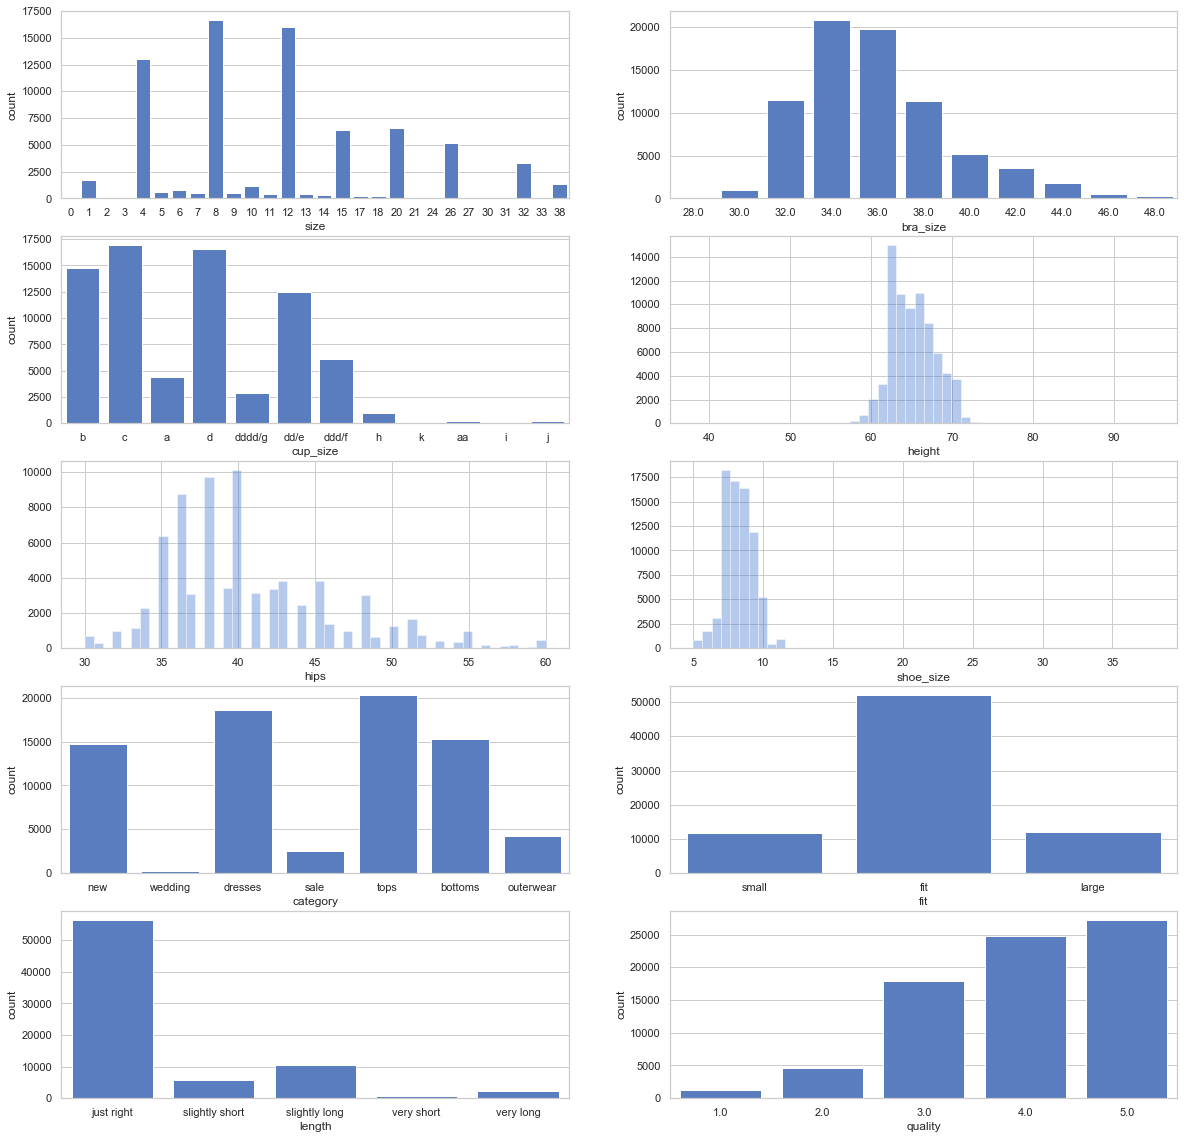

In [15]:
sns.set(style="whitegrid", palette="muted", color_codes=True)
fig,axes=plt.subplots(5, 2, figsize=(20, 20))
sns.countplot(data['size'],ax=axes[0,0], color='b')
sns.countplot(data['bra_size'],ax=axes[0,1], color='b')
sns.countplot(data['cup_size'],ax=axes[1,0], color='b')
sns.distplot(data['height'], kde=False, ax=axes[1,1], color='b')
sns.distplot(data['hips'], kde=False, ax=axes[2,0], color='b')
sns.distplot(data["shoe_size"], kde=False, ax=axes[2,1], color='b')
sns.countplot(data['category'],ax=axes[3,0], color='b')
sns.countplot(data['fit'],ax=axes[3,1], color='b')
sns.countplot(data['length'],ax=axes[4,0], color='b')
sns.countplot(data['quality'],ax=axes[4,1], color='b')





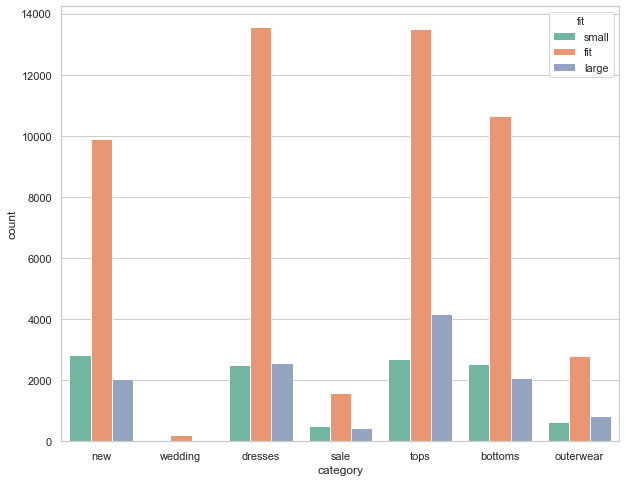

In [16]:
sns.set_style("whitegrid")
fig,axes=plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x="category",hue="fit",data=data,palette="Set2") 

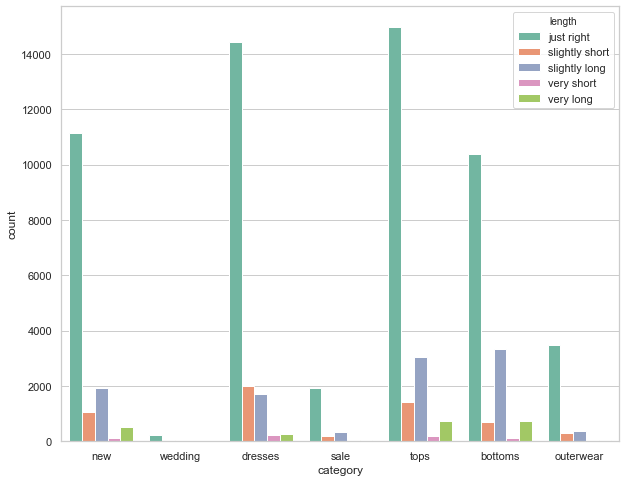

In [17]:
sns.set_style("whitegrid")
fig,axes=plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x="category",hue="length",data=data,palette="Set2") 


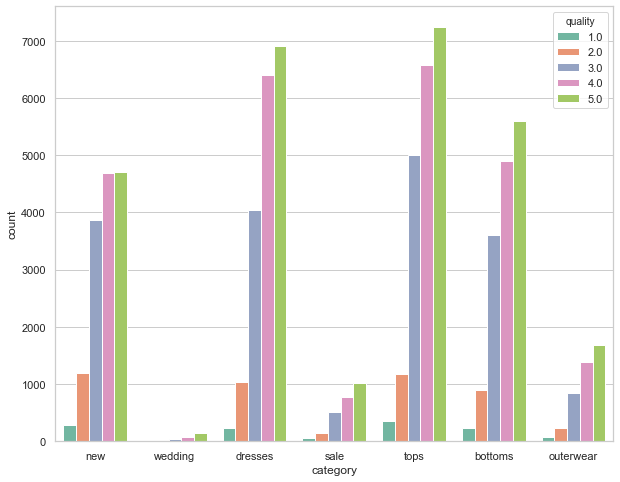

In [18]:
sns.set_style("whitegrid")
fig,axes=plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x="category",hue="quality",data=data,palette="Set2") 


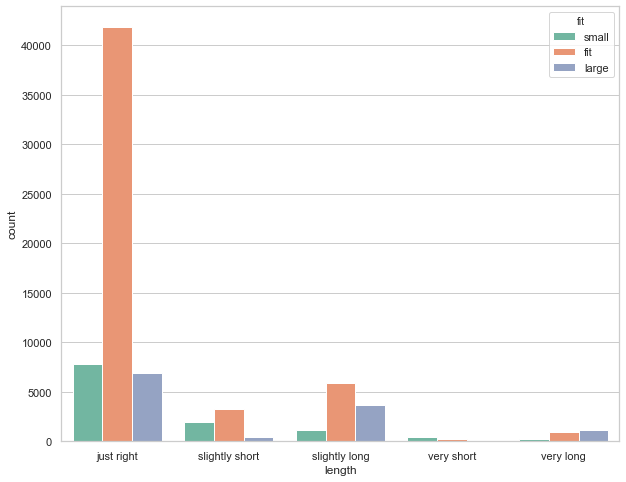

In [19]:
sns.set_style("whitegrid")
fig,axes=plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x="length",hue="fit",data=data,palette="Set2") 


In [47]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

fit_text = ''
small_text = ''
large_text = ''
for i in range(len(data)):
    try:
        if data['fit'][i] == 'fit':
            fit_text += data['review_text'][i]
        if data['fit'][i] == 'small':
            small_text += data['review_text'][i]
        if data['fit'][i] == 'large':
            large_text += data['review_text'][i]
    except: 
        continue

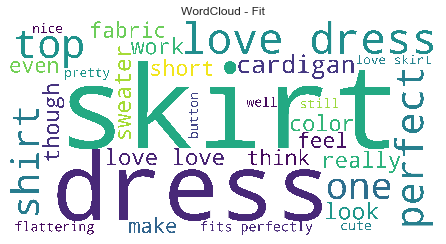

In [48]:
wordcloud_fit = WordCloud(stopwords=STOPWORDS,background_color='white',
                          width=6000,height=3000,max_words=30).generate(fit_text)
plt.imshow(wordcloud_fit)
plt.axis('off')
plt.tight_layout(pad = 0) 
plt.title('WordCloud - Fit')
plt.show()

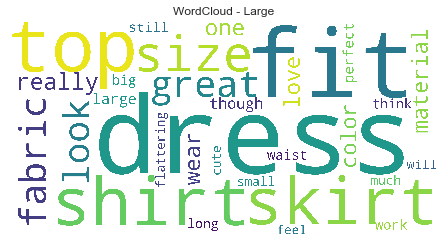

In [49]:
wordcloud_large = WordCloud(stopwords=STOPWORDS,background_color='white',
                          width=6000,height=3000,max_words=30).generate(large_text)
plt.imshow(wordcloud_large)
plt.axis('off')
plt.tight_layout(pad = 0) 
plt.title('WordCloud - Large')
plt.show()

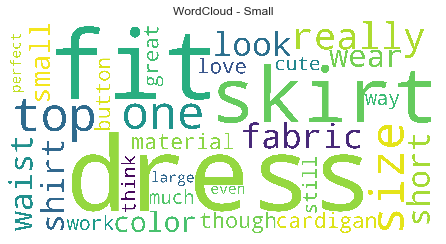

In [50]:
wordcloud_small = WordCloud(stopwords=STOPWORDS,background_color='white',
                          width=6000,height=3000,max_words=30).generate(small_text)
plt.imshow(wordcloud_small)
plt.axis('off')
plt.tight_layout(pad = 0) 
plt.title('WordCloud - Small')
plt.show()

In [64]:
def vader_score(texts):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(texts)
    
    compound=0
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        compound+=vs['compound']/(len(sentences))     
    return compound

In [66]:
data["Vadersocre"] = ""
for i in range(len(data)):
    try:
        data['Vadersocre'][i] = vader_score(data.iloc[i]['review_text'])
    except:
        continue   

In [82]:
fit_score=0
fit_counter=0
small_score=0
small_counter=0
large_score=0
large_counter=0
for i in range(len(data)):
    try:
        if data['fit'][i] == 'fit':
            fit_score += data['Vadersocre'][i]
            fit_counter += 1
        if data['fit'][i] == 'small':
            small_score += data['Vadersocre'][i]
            small_counter += 1

        if data['fit'][i] == 'large':
            large_score += data['Vadersocre'][i]
            large_counter += 1

    except: 
        continue
        
print(f'Vader score for fit item is {fit_score/fit_counter}')
print(f'Vader score for small item is {small_score/small_counter}')
print(f'Vader score for large item is {large_score/large_counter}')

Vader score for fit item is 0.38047721985598654
Vader score for small item is 0.38726627030685845
Vader score for large item is 0.38064865782078205


In [20]:
from sklearn.model_selection import train_test_split


dropped_data = data[data['category'].notnull() & data['review_summary'].notnull() & data['review_text'].notnull()]
rating_to_binary = (dropped_data["quality"] == 5.0) | (dropped_data["quality"] == 4.0) & (dropped_data["fit"] == "fit")
dropped_data["class_quality"] = np.where(rating_to_binary == True, 1, 0)

item_rating_count = pd.DataFrame(dropped_data.groupby("user_id")["quality"].count())
item_rating_count = item_rating_count.loc[(item_rating_count["quality"] > 3)]
item_rating_count.reset_index(inplace=True)
dropped_data = dropped_data[dropped_data["user_id"].isin(item_rating_count["user_id"])]

dropped_data.info()

data_train, data_test = train_test_split(dropped_data,
                                               stratify=dropped_data['user_id'],
                                               test_size=.2,
                                               random_state=1024)

print("Train size: {row:,}".format(row=data_train.shape[0]))
print("Test size: {row:,}".format(row=data_test.shape[0]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20548 entries, 6733 to 82785
Data columns (total 15 columns):
item_id           20548 non-null int64
size              20548 non-null int64
quality           20548 non-null float64
cup_size          20548 non-null object
hips              20548 non-null float64
bra_size          20548 non-null float64
category          20548 non-null object
height            20548 non-null float64
length            20548 non-null object
fit               20548 non-null object
user_id           20548 non-null int64
shoe_size         20548 non-null float64
review_summary    20548 non-null object
review_text       20548 non-null object
class_quality     20548 non-null int64
dtypes: float64(5), int64(4), object(6)
memory usage: 2.5+ MB
Train size: 16,438
Test size: 4,110


In [21]:
ratings = pd.DataFrame(data_train.groupby(['item_id','size'])['quality'].mean())

ratings.head()

quality
item_id size          
152702  4     3.888889
        8     3.818182
        12    3.878049
153494  4     3.800000
        8     3.571429

In [22]:
ratings['number_of_reviews'] = data_train.groupby(['item_id','size'])['quality'].count()
ratings.head()

quality  number_of_reviews
item_id size                             
152702  4     3.888889                 18
        8     3.818182                 33
        12    3.878049                 41
153494  4     3.800000                  5
        8     3.571429                  7

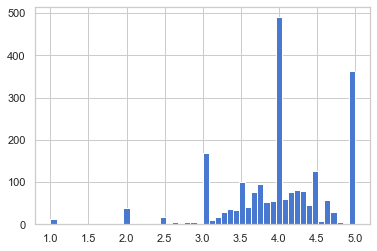

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
ratings['quality'].hist(bins=50)

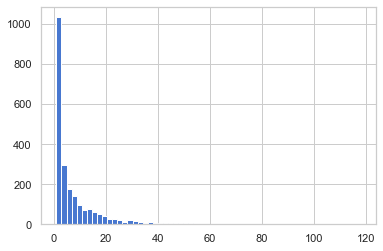

In [24]:
ratings['number_of_reviews'].hist(bins=60)

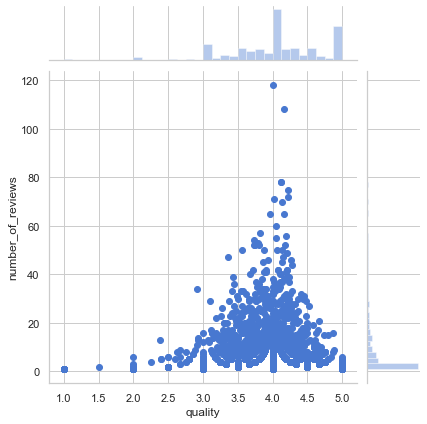

In [25]:
import seaborn as sns
sns.jointplot(x='quality', y='number_of_reviews', data=ratings)

In [26]:
cloth_matrix = data_train.pivot_table(index='user_id', columns=['item_id', 'size'], values='quality')
cloth_matrix.head()

item_id 152702          153494                     154411  ... 807252          \
size        4   8    12     4   8   12  20  26  32     4   ...     20  26  32   
user_id                                                    ...                  
66         NaN NaN  NaN    NaN NaN NaN NaN NaN NaN    NaN  ...    NaN NaN NaN   
238        NaN NaN  NaN    NaN NaN NaN NaN NaN NaN    NaN  ...    NaN NaN NaN   
1019       NaN NaN  NaN    NaN NaN NaN NaN NaN NaN    NaN  ...    NaN NaN NaN   
1134       NaN NaN  3.0    NaN NaN NaN NaN NaN NaN    NaN  ...    NaN NaN NaN   
1415       NaN NaN  NaN    NaN NaN NaN NaN NaN NaN    NaN  ...    NaN NaN NaN   

item_id 807384             807722          
size        4   8   12  20     4   8   12  
user_id                                    
66         NaN NaN NaN NaN    NaN NaN NaN  
238        NaN NaN NaN NaN    NaN NaN NaN  
1019       NaN NaN NaN NaN    NaN NaN NaN  
1134       NaN NaN NaN NaN    NaN NaN NaN  
1415       NaN NaN NaN NaN    NaN NaN NaN  

[5 rows x 2237 columns]

In [27]:
ratings.sort_values('number_of_reviews', ascending=False).head(10)

quality  number_of_reviews
item_id size                             
539980  12    4.008475                118
        8     4.166667                108
427567  12    4.128205                 78
        8     4.128205                 78
645822  12    4.226667                 75
539980  4     4.222222                 72
        20    4.014085                 71
630114  12    4.142857                 70
        8     4.169231                 65
645822  8     3.969231                 65

In [28]:
item_407134_8_user_rating = cloth_matrix[(407134, 8)]
item_668696_8_user_rating = cloth_matrix[(668696, 8)]

In [29]:
item_407134_8_user_rating.head()

user_id
66      NaN
238     4.0
1019    NaN
1134    NaN
1415    NaN
Name: (407134, 8), dtype: float64

In [30]:
item_668696_8_user_rating.head()

user_id
66      NaN
238     4.0
1019    NaN
1134    NaN
1415    NaN
Name: (668696, 8), dtype: float64

In [31]:
similar = cloth_matrix.corrwith(item_407134_8_user_rating)

In [32]:
similar.head()

item_id  size
152702   4       NaN
         8       NaN
         12      1.0
153494   4       NaN
         8       NaN
dtype: float64

In [33]:
similar2 = cloth_matrix.corrwith(item_668696_8_user_rating)
similar2.head()

item_id  size
152702   4      NaN
         8      NaN
         12     NaN
153494   4      NaN
         8      NaN
dtype: float64

In [34]:
corr_1 = pd.DataFrame(similar, columns=['Correlation'])
corr_1.dropna(inplace=True)
corr_1.head()
corr_2 = pd.DataFrame(similar2, columns=['correlation'])
corr_2.dropna(inplace=True)
corr_2.head()

correlation
item_id size             
416942  4        1.000000
        8       -0.866025
422651  8        1.000000
427567  8       -0.522233
454030  4        1.000000

In [35]:
corr_1 = corr_1.join(ratings['number_of_reviews'])
corr_2 = corr_2.join(ratings['number_of_reviews'])
corr_1.head()
corr_2.head()

correlation  number_of_reviews
item_id size                                
416942  4        1.000000                 56
        8       -0.866025                 55
422651  8        1.000000                  8
427567  8       -0.522233                 78
454030  4        1.000000                 32

In [36]:
corr_1[corr_1['number_of_reviews'] > 1].sort_values(by='Correlation', ascending=False).head(20)

,,Correlation,number_of_reviews
item_id,size,,
152702,12,1.000000,41
693560,8,1.000000,52
269063,9,1.000000,18
486643,4,1.000000,52
657242,10,1.000000,36
630114,12,1.000000,70
454764,12,1.000000,45
412737,12,1.000000,52
407134,8,1.000000,47


In [37]:
corr_2[corr_2['number_of_reviews'] > 1].sort_values(by='correlation', ascending=False).head(20)

,,correlation,number_of_reviews
item_id,size,,
416942,4,1.000000,56
668696,8,1.000000,49
715662,8,1.000000,41
422651,8,1.000000,8
454030,4,1.000000,32
722362,10,1.000000,18
507565,8,1.000000,24
645822,8,1.000000,65
656645,4,1.000000,21


In [38]:
def findRecommendation(itemId, size):
    itemRating = cloth_matrix[(itemId, size)]
    similar = cloth_matrix.corrwith(itemRating)
    corr = pd.DataFrame(similar, columns=['Correlation'])
    corr.dropna(inplace=True)
    corr = corr.join(ratings['number_of_reviews'])
    print("For item:" + str(itemId) + " with size " + str(size) + " we recommend these items with these sizes:")
    print(corr[corr['number_of_reviews'] > 1].sort_values(by='Correlation', ascending=False).head(20))

In [39]:
findRecommendation(539980, 12)

For item:539980 with size 12 we recommend these items with these sizes:
              Correlation  number_of_reviews
item_id size                                
298256  8        1.000000                 19
645536  12       1.000000                 16
539980  12       1.000000                118
168387  12       1.000000                 13
752094  8        1.000000                 33
454764  20       1.000000                 19
338596  8        1.000000                 21
655211  15       1.000000                 15
156364  12       1.000000                 14
654585  12       1.000000                 25
656645  8        1.000000                 29
492279  12       1.000000                 18
412003  12       1.000000                 24
707014  8        1.000000                 15
712030  12       1.000000                 23
753935  15       1.000000                 33
757242  8        1.000000                 22
481011  12       0.981981                 20
760407  12       0.981981   

In [40]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

data_train["item_review_text"] = (data_train["category"] + 
                                    " " +
                                    data_train["review_summary"] +
                                    " " +
                                    data_train["review_text"]).str.lower()
data_train["item_review_text"] = data_train["item_review_text"].astype(str)
data_train["item_review_text"] = data_train["item_review_text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop_words)])
)

data_train[["item_id", "item_review_text"]].tail()

,item_id,item_review_text
55438,633619,tops looks really cute looks really cute fabri...
73016,753429,"bottoms bought si bought size larger, fits wel..."
70369,723208,bottoms simple leggings. wha simple leggings. ...
81672,806479,outerwear i'm normally size xlxxl i'm normally...
75755,757731,bottoms tad snuggling tad snuggling tried pop ...


In [41]:
agg_item_text = pd.DataFrame(data_train.groupby("item_id")["item_review_text"].sum())
agg_item_text.head()

,item_review_text
item_id,
152702,new absolutely love dr absolutely love dress! ...
153494,"new bit stiff mat bit stiff material, bit chea..."
154411,new love di love dino dress?!new wanted love d...
155256,new waistband area rat waistband area rather s...
155530,"wedding really pretty, really pretty, especial..."


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
tf_idf_matrix = tf_idf.fit_transform(agg_item_text["item_review_text"])
item_tfidf_similarity = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
item_tfidf_similarity_df = pd.DataFrame(item_tfidf_similarity,
                                        columns=agg_item_text.index,
                                        index=agg_item_text.index)

item_tfidf_similarity_df.head()

item_id,152702,153494,154411,155256,155530,155572,156364,157334,158308,158723,...,803464,803768,804295,805172,805642,806479,806856,807252,807384,807722
item_id,,,,,,,,,,,,,,,,,,,,,
152702,1.000000,0.712795,0.721895,0.552143,0.388061,0.323672,0.660073,0.173082,0.182384,0.126373,...,0.222665,0.206239,0.143189,0.134547,0.129724,0.168681,0.171959,0.183291,0.162263,0.174199
153494,0.712795,1.000000,0.704941,0.510493,0.346077,0.298369,0.612183,0.167459,0.197869,0.109459,...,0.197471,0.187389,0.133187,0.127965,0.110878,0.159649,0.161634,0.177948,0.160644,0.154488
154411,0.721895,0.704941,1.000000,0.514921,0.316717,0.242950,0.626423,0.155330,0.157660,0.104644,...,0.188926,0.185307,0.166472,0.126366,0.126344,0.159776,0.160281,0.176713,0.152003,0.145397
155256,0.552143,0.510493,0.514921,1.000000,0.383672,0.301366,0.449507,0.119731,0.152594,0.146199,...,0.126855,0.115497,0.091044,0.083184,0.091748,0.094461,0.116698,0.107294,0.056861,0.096848
155530,0.388061,0.346077,0.316717,0.383672,1.000000,0.531910,0.322073,0.067596,0.084281,0.250527,...,0.122225,0.110021,0.046103,0.071886,0.081517,0.090926,0.101966,0.093475,0.083202,0.100684


In [43]:
tf_idf_matrix

<600x11797 sparse matrix of type '<class 'numpy.float64'>'
	with 128517 stored elements in Compressed Sparse Row format>

In [44]:
def recommender_test_eval(recommendations, user):
    
    user_pref = data_test[data_test.user_id.isin([user])]
    items_in_60 = user_pref[user_pref.item_id.isin(recommendations.item_id)]
    
    recall_dict = {"user_id": user,
                   "ratings_count": len(user_pref),
                   "accurate_at_60": len(items_in_60[items_in_60.class_quality == 1]),
                   "recall_at_60": len(items_in_60[items_in_60.class_quality == 1]) / len(user_pref)}
                    
    return recall_dict

recommender_method_eval = pd.DataFrame()

def recommender_eval_gather(recommender, method, result=None):
        
    if recommender == None:
        method_result = pd.DataFrame({"Method": method, "Recall_mean@60": [result.mean()]})
        all_results = recommender_method_eval.append(method_result)
        
    else:
        result = pd.DataFrame([recommender(user) for user in data_test["user_id"].unique()], 
                               columns=["user_id", "accurate_at_60", "ratings_count", "recall_at_60"])
        method_result = pd.DataFrame({"Method": method, "Recall_mean@60": [result["recall_at_60"].mean()]})
        all_results = recommender_method_eval.append(method_result)
    
    return recommender_method_eval.append(all_results).sort_values("Recall_mean@60", ascending = False).drop_duplicates()

In [45]:
def tfidf_content_recommender(id):
    top_train_user_item = data_train[data_train.user_id == id][:1]
    top_train_user_item = int(top_train_user_item.item_id)
    item_similarities = item_tfidf_similarity_df[[top_train_user_item]].sort_values([top_train_user_item], ascending=False)
    top_60 = item_similarities.iloc[1:61]
    top_60.reset_index(inplace=True)
                    
    return recommender_test_eval(recommendations = top_60, user = id)

In [46]:
recommender_method_eval = recommender_eval_gather(recommender = tfidf_content_recommender, method = "Item_tfidf")
recommender_method_eval

,Method,Recall_mean@60
0,Item_tfidf,0.212778


Item Recommendation -- Collaborative Filtering

In [ ]:
data = pd.read_csv('data.csv') #data after preprocessing

In [ ]:
def vader_score(texts):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(texts)
    
    compound=0
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        compound+=vs['compound']/(len(sentences))     
    return compound

In [ ]:
data["Vaderscore"] = ""
for i in range(len(data)):
    try:
        data['Vaderscore'][i] = vader_score(data.iloc[i]['review_text'])
    except:
        continue   

In [ ]:
data['rating']=data["Vaderscore"]

In [ ]:
#check how many rows don't have vaderscore
count = 0
for i in range(len(data)):
    if isinstance(data['Vaderscore'][i],str):
        count += 1
print(count)   

In [ ]:
count = 0
for i in range(len(data)):
    if data['Vaderscore'][i] == 0.0:
        count += 1
print(count)

In [ ]:
#Because only 7 rows don't have a vaderscore, transfer them to 0
data['rating']=data["Vaderscore"]
for i in range(len(data)):
    if isinstance(data['rating'][i],str):
        data['rating'][i] = 0.0   

In [ ]:
sns.distplot(data['rating'], kde=False)

In [ ]:
df = data[['user_id','item_id','rating']] #Only use these 3 rows for the recommendation
item = data['item_id'].unique()
ueser = data['user_id'].unique()

In [ ]:
#change the vaderscore to rating 1-5
for i in range(len(df)):
    if df['rating'][i] <= 0:
        df['rating'][i] = 1
    elif 0 < df['rating'][i] < 0.3:
        df['rating'][i] = 2
    elif 0.3 <= df['rating'][i] < 0.5:
        df['rating'][i] = 3
    elif 0.5 <= df['rating'][i] < 0.75:
        df['rating'][i] = 4
    else:
        df['rating'][i] = 5

In [ ]:
df

In [ ]:
sns.distplot(df['rating'], kde=False)

In [ ]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of items = ' + str(n_items))

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.25)

In [ ]:
train_data_matrix = pd.DataFrame(np.zeros((n_users, n_items)),index=df['user_id'].unique(),columns=df['item_id'].unique())
for line in train_data.itertuples():
    train_data_matrix.loc[line[1], line[2]] = line[3]

In [ ]:
test_data_matrix = pd.DataFrame(np.zeros((n_users, n_items)),index=df['user_id'].unique(),columns=df['item_id'].unique())
for line in test_data.itertuples():
    test_data_matrix.loc[line[1], line[2]] = line[3]

In [ ]:
# Using pairwise distance to calculate the similarity
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [ ]:
def predict(ratings, similarity, type):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])    
    return pred

In [ ]:
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

In [ ]:
item_prediction.columns = df['item_id'].unique()
item_prediction

In [ ]:
user_prediction = pd.DataFrame(user_prediction,index=df['user_id'].unique(),columns=df['item_id'].unique())
user_prediction

In [ ]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [ ]:
user_based_test_rmse = rmse(np.array(user_prediction), np.array(test_data_matrix))
item_based_test_rmse = rmse(np.array(item_prediction), np.array(test_data_matrix))

In [ ]:
print('User-based CF RMSE: ' + str(user_based_test_rmse))
print('Item-based CF RMSE: ' + str(item_based_test_rmse))

In [ ]:
print('User-based Train RMSE: ' + str(rmse(np.array(user_prediction), np.array(train_data_matrix))))
print('Item-based Train RMSE: ' + str(rmse(np.array(item_prediction), np.array(train_data_matrix))))

In [ ]:
def product_recommendation(user_id, type):
    if type == 'user':
        similiar_dict = dict(user_prediction.loc[user_id])
        similiar_dict = sorted(similiar_dict.items(),key = lambda x:x[1],reverse = True)[:5]
        recommendation_list = [i[0] for i in similiar_dict]
    elif type == 'item':
        similiar_dict = dict(item_prediction.loc[user_id])
        similiar_dict = sorted(similiar_dict.items(),key = lambda x:x[1],reverse = True)[:5]
        recommendation_list = [i[0] for i in similiar_dict]
    return recommendation_list

In [ ]:
user_id = 52664
recommendation_item = set(product_recommendation(user_id, 'user') + product_recommendation(user_id, 'item'))
print('The recommendation product for user '+str(user_id)+':', list(recommendation_item))